In [1]:
from PIL import Image
from pytesseract import image_to_string

'''
Python 3 only! To use this you need to install tesseract FIRST (not via pip)
Then use pip to install PIL, pytesseract, and cv2
'''

def process(k,img):
    if k != 'level' and k != 'plus':
        thresh = cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU
        low = 0
        #proc = cv2.cvtColor(cv2.medianBlur(cv2.threshold(cv2.cvtColor(cv2.resize(img, (0,0), fx=5, fy=5), cv2.COLOR_BGR2GRAY),low,255,thresh)[1], 3), cv2.COLOR_BGR2RGB)
        resize = cv2.resize(img, (0,0), fx=5, fy=5) # Increase resolution to make OCR more reliable
        gray = cv2.cvtColor(resize, cv2.COLOR_BGR2GRAY) # Turn gray
        threshold = cv2.threshold(gray,low,255,thresh)[1] # Thresholding
        blur = cv2.medianBlur(threshold, 3) # Blurring
        proc = cv2.cvtColor(blur, cv2.COLOR_BGR2RGB) # Convert color scheme for Image
        pil = Image.fromarray(proc) # Convert img format to that used by pytesseract
        data = image_to_string(pil, lang='eng', config='--psm 6')
    else:
        thresh = cv2.THRESH_BINARY
        low = 50
        # Here I just collapse all of that ('resize' through 'proc') into a single line
        proc = cv2.cvtColor(cv2.medianBlur(cv2.threshold(~cv2.cvtColor(cv2.resize(img, (0,0), fx=5, fy=5), cv2.COLOR_BGR2GRAY),low,255,thresh)[1], 3), cv2.COLOR_BGR2RGB)
        data = image_to_string(Image.fromarray(proc), lang='eng', config='--psm 7')
        if not any(i.isdigit() for i in data):
            low = 100
            proc = cv2.cvtColor(cv2.medianBlur(cv2.threshold(~cv2.cvtColor(cv2.resize(img, (0,0), fx=5, fy=5), cv2.COLOR_BGR2GRAY),low,255,thresh)[1], 3), cv2.COLOR_BGR2RGB)
            data = image_to_string(Image.fromarray(proc), lang='eng', config='--psm 7')
            if not any(i.isdigit() for i in data):
                low = 125
                proc = cv2.cvtColor(cv2.medianBlur(cv2.threshold(~cv2.cvtColor(cv2.resize(img, (0,0), fx=5, fy=5), cv2.COLOR_BGR2GRAY),low,255,thresh)[1], 3), cv2.COLOR_BGR2RGB)
                data = image_to_string(Image.fromarray(proc), lang='eng', config='--psm 7')
    return data

def stat_converter(stat):
    result = ''
    if 'attack' in stat.lower():
        result = 'Atk'
        if '%' in stat: result += 'P'
    if 'health' in stat.lower():
        result = 'HP'
        if '%' in stat: result += 'P'
    if 'defense' in stat.lower():
        result = 'Def'
        if '%' in stat: result += 'P'
    if 'speed' in stat.lower(): result = 'Spd'
    if 'chance' in stat.lower(): result = 'CChance'
    if 'damage' in stat.lower(): result = 'CDmg'
    if 'effectiveness' in stat.lower(): result = 'Eff'
    if 'resistance' in stat.lower(): result = 'Res'
    return result

def digit_filter(val):
    return int(''.join(filter(str.isdigit,val)))

def char_filter(val):
    return ''.join(filter(str.isalpha,val)).capitalize()

In [2]:
from glob import glob
from string import ascii_lowercase, digits
import random
import cv2

'''
This is for 1080x2200 only. If you want to adapt it to another resolution you need to take new template screenshots
for anchoring the top and bottom boxes. Then you need to redo all the coordinates for the small boxes within each chunk
'''

# Format for optimizer
'''This will erase any heroes you have entered into the optimizer. If you want to keep your heroes you need to export
them first and then copy and paste the data in "heroes":[] into the line below'''
export = {"processVersion":"1","heroes":[],"items":[]} #

# Iterate through the files
filenames = glob('screenshots/*')
#filenames = ['screenshots/Screenshot_20190322-115231.jpg'] #uncomment this to test for a single image
for name in filenames:
    '''
    Because the height of the item boxes changes depending on the length of the item and set descriptions, we have
    to crop the top and bottom info separately in order to ensure the OCR boxes within these areas stay fixed
    '''
    
    # All the print lines are currently uncommented so you can see how it works. Comment them to make it run silently!
    
    img = cv2.imread(name)
    print(name)
    
    # Top Box
    temp_top = cv2.imread('e7/top.jpg',0)
    _, _, _, max_loc = cv2.minMaxLoc(cv2.matchTemplate(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), temp_top, cv2.TM_CCOEFF_NORMED))
    top_box = img[max_loc[1]:max_loc[1]+160,740:1190] # Fixed width, then crop 160 pixels from top triangle
    #cv2.imwrite('e7/top_box.jpg', top_box) # Uncomment this to see what the top box looks like

    # Bottom Box
    # The image template
    temp_bot = cv2.imread('e7/bottom.jpg',0)
    _, _, _, max_loc = cv2.minMaxLoc(cv2.matchTemplate(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), temp_bot, cv2.TM_CCOEFF_NORMED))
    bottom_box = img[max_loc[1]+25:max_loc[1]+360,740:1190] # Fixed width, shift down 25 from divider, then crop 335 pixels deep
    #cv2.imwrite('e7/bottom_box.jpg', bottom_box) # Uncomment this to see what the bottom box looks like

    # Setup item dictionary
    id_num = "jt"+"".join(random.choice(digits+ascii_lowercase) for _ in range(6))
    item = {"locked":False,"efficiency":0,"id":id_num}

    # Process top image
    top_coords = {'type': [[20,70],[172,432]],
                  'level': [[19,44],[37,66]],
                  'plus': [[11,34],[139,168]]}
    for k in top_coords.keys():
        data = process(k,top_box[top_coords[k][0][0]:top_coords[k][0][1],top_coords[k][1][0]:top_coords[k][1][1]])
        print(data)
        if k == 'type':
            item["rarity"] = char_filter(data.split(' ')[0])
            item["slot"] = char_filter(data.split(' ')[1].split('\n')[0])
        if k == 'level':
            # Tesseract will consistently misrecognize certain digits. The 'replace' function is correcting for
            # the ones found so far. Feel free to add to it if you find more
            item["level"] = digit_filter(data.replace('S','5').replace('B','8').replace('a','8'))
        if k == 'plus':
            item["ability"] = digit_filter(data.replace('S','5').replace('B','8').replace('a','8'))

    # Process bottom image
    bot_coords = {'main': [[8,70],[65,435]],
                  'subs': [[98,255],[25,435]],
                  'set': [[280,340],[76,435]]}
    for k in bot_coords.keys():
        data = process(k,bottom_box[bot_coords[k][0][0]:bot_coords[k][0][1],bot_coords[k][1][0]:bot_coords[k][1][1]])
        if k == 'main':
            print(data)
            stat = stat_converter(data)
            val = digit_filter(data)
            item["mainStat"] = [stat,val]
        if k == 'subs':
            print(data.split('\n'))
            for n,entry in enumerate(data.split('\n')):
                stat = stat_converter(entry)
                # Same deal here. Tesseract occasionally misreads 7% as T%
                val = digit_filter(entry.replace('T%','7%'))
                item['subStat'+str(n+1)] = [stat,val]
        if k == 'set':
            print(data)
            item["set"] = char_filter(data.split(' Set')[0])
    export["items"].append(item)
    print(item)

screenshots/Screenshot_20190322-115231.jpg
Epic Ring
85
15
Attack 60%
['Health 5%', 'Speed 6', 'Critical Hit Chance 17%', 'Effectiveness 13%']
Lifesteal Set (0/4)
{'locked': False, 'efficiency': 0, 'id': 'jtl96f57', 'rarity': 'Epic', 'slot': 'Ring', 'level': 85, 'ability': 15, 'mainStat': ['AtkP', 60], 'subStat1': ['HPP', 5], 'subStat2': ['Spd', 6], 'subStat3': ['CChance', 17], 'subStat4': ['Eff', 13], 'set': 'Lifesteal'}


In [3]:
# Sanity Check to ensure all files were added to the dict
print(len(export['items']),len(filenames))

1 1


In [4]:
import json

# Export to json for importing into optimizer: https://eseo-8a854.firebaseapp.com/
with open('e7/max.json', 'w') as fp: json.dump(export, fp)

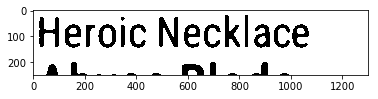

'Heroic Necklace\ngai... geeae i § ._'

In [5]:
from matplotlib import pyplot as plt
import cv2

# TROUBLESHOOTING 'type'

img = cv2.imread('screenshots/test1.jpg')
temp_top = cv2.imread('e7/top.jpg',0)
_, _, _, max_loc = cv2.minMaxLoc(cv2.matchTemplate(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), temp_top, cv2.TM_CCOEFF_NORMED))
top_box = img[max_loc[1]:max_loc[1]+160,740:1190]

top_coords = {'type': [[20,70],[172,432]]}
k = 'type'
img = top_box[top_coords[k][0][0]:top_coords[k][0][1],top_coords[k][1][0]:top_coords[k][1][1]]
thresh = cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU
low = 0
proc = cv2.cvtColor(cv2.medianBlur(cv2.threshold(cv2.cvtColor(cv2.resize(img, (0,0), fx=5, fy=5), cv2.COLOR_BGR2GRAY),low,255,thresh)[1], 3), cv2.COLOR_BGR2RGB)
plt.imshow(proc)
plt.show()
image_to_string(Image.fromarray(proc),lang='eng',config='--psm 6')

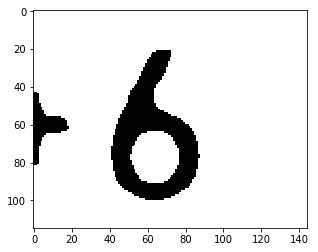

'+b'

In [6]:
from matplotlib import pyplot as plt
import cv2

# TROUBLESHOOTING 'plus' and 'level'

img = cv2.imread('screenshots/test2.jpg')
temp_top = cv2.imread('e7/top.jpg',0)
_, _, _, max_loc = cv2.minMaxLoc(cv2.matchTemplate(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), temp_top, cv2.TM_CCOEFF_NORMED))
top_box = img[max_loc[1]:max_loc[1]+160,740:1190]

top_coords = {'plus': [[11,34],[139,168]],
              'level': [[19,44],[37,66]]}
k = 'plus'
img = top_box[top_coords[k][0][0]:top_coords[k][0][1],top_coords[k][1][0]:top_coords[k][1][1]]
thresh = cv2.THRESH_BINARY
low = 50 # check 50, 100, 125
proc = cv2.cvtColor(cv2.medianBlur(cv2.threshold(~cv2.cvtColor(cv2.resize(img, (0,0), fx=5, fy=5), cv2.COLOR_BGR2GRAY),low,255,thresh)[1], 3), cv2.COLOR_BGR2RGB)
plt.imshow(proc)
plt.show()
image_to_string(Image.fromarray(proc),lang='eng',config='--psm 7')

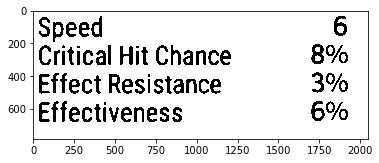

'Speed 6\nCritical Hit Chance 8%\nEffect Resistance 3%\nEffectiveness 6%'

In [7]:
from matplotlib import pyplot as plt
import cv2

# TROUBLESHOOTING 'main', 'subs', 'set'

img = cv2.imread('screenshots/Screenshot_20190322-115902.jpg')
temp_bot = cv2.imread('e7/bottom.jpg',0)
_, _, _, max_loc = cv2.minMaxLoc(cv2.matchTemplate(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), temp_bot, cv2.TM_CCOEFF_NORMED))
bottom_box = img[max_loc[1]+25:max_loc[1]+360,740:1190]

bot_coords = {'main': [[8,70],[65,435]],
              'subs': [[98,255],[25,435]],
              'set': [[280,330],[76,435]]}
k = 'subs'
img = bottom_box[bot_coords[k][0][0]:bot_coords[k][0][1],bot_coords[k][1][0]:bot_coords[k][1][1]]
thresh = cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU
low = 0
proc = cv2.cvtColor(cv2.medianBlur(cv2.threshold(cv2.cvtColor(cv2.resize(img, (0,0), fx=5, fy=5), cv2.COLOR_BGR2GRAY),low,255,thresh)[1], 3), cv2.COLOR_BGR2RGB)
plt.imshow(proc)
plt.show()
image_to_string(Image.fromarray(proc),lang='eng',config='--psm 6')